# Description

This notebook is used to tabulate final results and compare novel generated molecules vs HIV inhibitors vs Remdesivir which entered clinical trials just a few days ago.

## Now the best results and save to sdf for last double check tabulation in PyRx

In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
import random
import numpy as np
import rdkit.Chem.PropertyMol

In [2]:
# './generations/master_results_table_gen10.csv'

final = pd.read_csv('./generations/master_results_table_gen12.csv',sep=',')
final = final.sort_values('score', ascending=True)
print(final.shape)
final.head()

(13193, 7)


,id,gen,smile,source,weight,logp,score
0,ABZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1312.235,32.3335,-16.0
1,ABOH,12,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1286.367,34.1331,-15.8
2,ABKL,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1264.191,31.4891,-15.6
3,ABJD,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1384.386,34.3280,-15.6
4,ACIQ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,generated,1290.229,32.4477,-15.6


In [3]:
final_max = final.groupby("smile").max()[["score","gen"]].reset_index()
final_max = final_max.sort_values('score', ascending=True)
print(final_max.shape)
final_max.head()

(13136, 3)


,smile,score,gen
7448,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-16.0,11
6177,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-15.8,12
7485,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-15.6,11
7207,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,-15.6,11
7450,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-15.6,10


In [4]:
final_joined = pd.merge(final_max, final, on=['smile','gen'], suffixes=('_old','_new'), how='left')

# final_joined = final_joined[(final_joined['score_new'] <= -15.0) & (final_joined['weight'] < 900)]
final_joined = final_joined[(final_joined['score_new'] <= -7.8) & (final_joined['logp']<5)]

final_joined['score'] = final_joined['score_new']
final_joined = final_joined.drop('score_old', axis=1)
final_joined = final_joined.drop('score_new', axis=1)
print(final_joined.shape)
final_joined.head(5)

(1222, 7)


,smile,gen,id,source,weight,logp,score
117,CC1C=CC=C(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,12,AAWE,generated,703.727,4.9502,-13.6
187,CC1C=CC=C(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,12,ABQA,generated,815.779,2.3371,-13.3
297,CC1CCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2=O)...,12,AANY,generated,693.732,4.8744,-13.1
343,CC1C=CCCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,12,ABFU,generated,671.682,3.4789,-13.0
400,CC1C=CCCC(C(=O)Nc2nnnn2-c2ccccc2C2=CC=C(C(=O)N...,12,ABDR,generated,561.566,2.3443,-12.8


In [7]:
final_table.head()

,id,gen,smile,source,weight,logp,score,score_best,score_avg,similarity_to_hiv_inhibitors,similarity_to_remdesivir
0,AAWE,12,CC1C=CC=C(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,generated,703.727,4.9502,-13.6,-13.6,-12.933333,0.451717,0.607641
1,ABQA,12,CC1C=CC=C(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,generated,815.779,2.3371,-13.3,-13.3,-12.377778,0.487943,0.680991
2,AANY,12,CC1CCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2=O)...,generated,693.732,4.8744,-13.1,-13.1,-11.988889,0.449364,0.585162
3,ABFU,12,CC1C=CCCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,generated,671.682,3.4789,-13.0,-13.0,-12.211111,0.456178,0.603842
4,ABDR,12,CC1C=CCCC(C(=O)Nc2nnnn2-c2ccccc2C2=CC=C(C(=O)N...,generated,561.566,2.3443,-12.8,-12.8,-11.500000,0.444924,0.597517


In [8]:
# Note I also manually added Remdesivir because as working on this it went into clinical trials
# https://en.wikipedia.org/wiki/Remdesivir

final_table.to_csv(r'./generations/master_results_table_final.csv', index=False)

In [9]:
final_table = pd.read_csv('./generations/master_results_table_final.csv')
final_table.tail()

,id,gen,smile,source,weight,logp,score,score_best,score_avg,similarity_to_hiv_inhibitors,similarity_to_remdesivir
18,AATK,12,CC1C=CCCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,generated,643.672,3.76360,-12.2,-12.2,-10.877778,0.453065,0.591879
19,ABXM,11,C#CC1=CCCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C...,generated,639.640,3.12050,-12.2,-12.2,-11.500000,0.462061,0.619295
20,AAXS,12,Cc1ccc(-n2nnnc2NC(=O)C2C=CC(C)c3ccccc3-c3ccccc...,generated,605.579,1.72132,-12.1,-12.1,-11.400000,0.461884,0.636033
21,AACW,12,CC1C=CCCC(C(=O)Nc2nnnn2C2=CC=C(C(=O)Nc3nnnnn3)...,generated,637.664,4.14660,-12.1,-12.1,-11.533333,0.445732,0.597612
22,AABM,12,CC=CCNc1nnnn1-c1ccccc1,genetic_algorithm,215.260,1.65030,-12.3,-6.7,-5.755556,0.191919,0.212261


In [10]:
def set_molecule(row):
    mol = Chem.MolFromSmiles(row['smile'])
    pm = Chem.PropertyMol.PropertyMol(mol)
    title = 'id' + str(row['id']) + 'gen'+ str(row['gen'])
    # print(title)
    # Enables for tracking which molecule is which in PyRx GUI and PyRx results export
    pm.SetProp('Title', title)
    return pm

In [11]:
mols_for_export = final_table.apply(set_molecule, axis=1)
# list(mols_for_export)

In [12]:
len(mols_for_export)

23

In [358]:
w = Chem.SDWriter('./generations/genfinal.sdf')
for m in mols_for_export:
    w.write(m)

#Rerun everything through PyRx once more to double check, then publish final metrics

In [360]:
dfs = []

# new_scores = pd.read_csv('./generations/results/results_gen12.csv',sep=',')

for i in range(0, 13):
    dfs.append(pd.read_csv('./generations/results/results_gen' + str(i) +'.csv',sep=','))

# Concatenate all data into one DataFrame
new_scores = pd.concat(dfs, ignore_index=True)

In [361]:
# new_scores = pd.read_csv('./generations/results/results_genfinal.csv',sep=',')
final_table = pd.read_csv('./generations/master_results_table_gen12.csv')
new_scores.head()

,Ligand,Binding Affinity,rmsd/ub,rmsd/lb
0,6lu7_idAAAAgen0,-6.7,0.000,0.000
1,6lu7_idAAAAgen0,-6.6,2.125,1.628
2,6lu7_idAAAAgen0,-6.4,9.023,3.692
3,6lu7_idAAAAgen0,-6.4,6.626,3.987
4,6lu7_idAAAAgen0,-6.3,6.182,4.837


In [362]:
new_scores = new_scores.groupby("Ligand").agg({'Binding Affinity': [np.min,np.average]}).reset_index()
new_scores.head()

Ligand Binding Affinity           
                                              amin    average
0   6LU7_idAAAAgen10_uff_E=112.89             -4.8  -4.511111
1   6LU7_idAAAAgen10_uff_E=178.91             -4.7  -4.377778
2  6LU7_idAAAAgen11_uff_E=3389.13            -11.0 -10.255556
3    6LU7_idAAAAgen11_uff_E=95.55             -4.1  -3.877778
4    6LU7_idAAAAgen12_uff_E=-0.64             -3.2  -3.000000

In [363]:
new_scores['id'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[0].str.split("id").str[1]
new_scores['gen'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[1]
new_scores['score_best'] = new_scores["Binding Affinity"]["amin"]
new_scores['score_avg'] = new_scores["Binding Affinity"]["average"]
new_scores = new_scores[['id','gen','score_best','score_avg']]

new_scores.head()
new_scores.dropna()

,id,gen,score_best,score_avg
,,,,
0,AAAA,10,-4.8,-4.511111
1,AAAA,10,-4.7,-4.377778
2,AAAA,11,-11.0,-10.255556
3,AAAA,11,-4.1,-3.877778
4,AAAA,12,-3.2,-3.000000
...,...,...,...,...
14732,ABTC,0,-7.8,-7.088889
14733,ABTD,0,-6.5,-6.144444
14734,ABTE,0,-7.9,-7.488889


In [364]:
final_table = final_table[final_table.score != 99.9]

In [365]:
final_table.describe()

,gen,weight,logp,score
count,12396.000000,12396.000000,12396.000000,12396.000000
mean,5.945628,429.666887,7.080610,-7.241683
std,4.024325,371.210861,10.892971,2.702995
min,0.000000,28.054000,-9.704780,-16.000000
25%,2.000000,180.207000,1.436450,-8.800000
50%,6.000000,297.358000,2.579710,-6.600000
75%,10.000000,486.571500,5.125115,-5.200000
max,12.000000,1767.402000,49.152600,-1.000000


In [366]:
new_scores.id = new_scores.id.astype(str)
new_scores.gen = new_scores.gen.astype(str)

final_table.id = final_table.id.astype(str)
final_table.gen = final_table.gen.astype(str)

In [367]:
new_table = pd.merge(final_table, new_scores, on=['id','gen'], suffixes=('_old','_new'), how='left')
new_table['score_best'] = new_table[('score_best', '')]
new_table['score_avg'] = new_table[('score_avg', '')]

new_table = new_table.drop([('score_best', ''),('score_avg', '')], axis=1)
new_table = new_table.sort_values('score_best', ascending=True)

new_table.dropna()
new_table.head()

C:\Users\user\Anaconda3\envs\tfv2\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,id,gen,smile,source,weight,logp,score,score_best,score_avg
0,ABZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1312.235,32.3335,-16.0,-16.0,-14.466667
1,ABOH,12,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1286.367,34.1331,-15.8,-15.8,-13.966667
2,ABKL,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1264.191,31.4891,-15.6,-15.6,-13.460000
3,ABJD,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1384.386,34.3280,-15.6,-15.6,-13.683333
4,ACIQ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,generated,1290.229,32.4477,-15.6,-15.6,-13.625000


In [368]:
new_table = pd.merge(final_table, new_scores, on=['id','gen'], suffixes=('_old','_new'), how='left')

new_table['score_best'] = new_table[('score_best', '')]
new_table['score_avg'] = new_table[('score_avg', '')]

new_table = new_table.drop([('score_best', ''),('score_avg', '')], axis=1)
new_table = new_table.sort_values('score_best', ascending=True)

new_table.dropna()
new_table.head(100)

C:\Users\user\Anaconda3\envs\tfv2\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,id,gen,smile,source,weight,logp,score,score_best,score_avg
0,ABZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1312.235,32.3335,-16.0,-16.0,-14.466667
1,ABOH,12,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1286.367,34.1331,-15.8,-15.8,-13.966667
2,ABKL,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1264.191,31.4891,-15.6,-15.6,-13.460000
3,ABJD,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1384.386,34.3280,-15.6,-15.6,-13.683333
4,ACIQ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,generated,1290.229,32.4477,-15.6,-15.6,-13.625000
...,...,...,...,...,...,...,...,...,...
96,AADM,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1126.107,30.2142,-13.8,-13.8,-12.055556
97,ACEI,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCC=CC=CC=CC=CC=CC...,generated,1081.755,25.3840,-13.8,-13.8,-12.200000
95,AAHN,11,C#CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1089.989,28.1629,-13.8,-13.8,-11.944444
94,ABGB,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC=CC=CC=CC=CC...,generated,989.614,23.7277,-13.8,-13.8,-11.788889


In [369]:
new_table.gen.unique()

array(['11', '12', '10', '9', '8', '6', '5', '4', '2', '3', '0', '1', '7'],
      dtype=object)

In [370]:
new_table[new_table.gen == '12']

,id,gen,smile,source,weight,logp,score,score_best,score_avg
1,ABOH,12,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1286.367,34.1331,-15.8,-15.8,-13.966667
6,AANI,12,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1292.245,32.2693,-15.5,-15.5,-13.880000
12,AAIR,12,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1324.501,35.8533,-15.1,-15.1,-13.366667
26,AAVG,12,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1108.048,29.4739,-14.6,-14.6,-13.275000
25,AAWC,12,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1276.202,31.8352,-14.6,-14.6,-12.600000
...,...,...,...,...,...,...,...,...,...
12505,AAME,12,C#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC...,generated,750.730,1.7597,-1.5,-1.5,-1.388889
12506,ABCV,12,C#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC...,generated,762.741,1.6011,-1.4,-1.4,-1.300000
12507,ABBC,12,C#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC...,generated,736.703,0.7381,-1.4,-1.4,-1.122222
12508,ABHB,12,C#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC#CC...,generated,746.698,0.3514,-1.3,-1.3,-1.222222


In [371]:
new_table.columns

Index(['id', 'gen', 'smile', 'source', 'weight', 'logp', 'score', 'score_best',
       'score_avg'],
      dtype='object')

In [380]:
# Add HIV inhibitors manually into the table
hiv_smiles = pd.read_csv('./datasets/hiv_inhibitors_cleaned.smi',sep=',', header=None)
hiv_smiles_list = list(hiv_smiles[0])

for smile in hiv_smiles_list:
    hiv_fingerprints.append(Chem.RDKFingerprint(Chem.MolFromSmiles(smile)))

def calc_hiv_similarity_score(row):
    fingerprint = Chem.RDKFingerprint(Chem.MolFromSmiles(row['smile']))
    similarity = np.mean(DataStructs.BulkTanimotoSimilarity(fingerprint,hiv_fingerprints))
    return similarity

remdesivir_fingerprint = Chem.RDKFingerprint(Chem.MolFromSmiles('CCC(CC)COC(=O)[C@H](C)NP(=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'))

new_table['similarity_to_hiv_inhibitors'] = new_table.apply(calc_hiv_similarity_score, axis=1)
new_table['similarity_to_remdesivir'] = new_table['smile'].apply(lambda x: DataStructs.TanimotoSimilarity(Chem.RDKFingerprint(Chem.MolFromSmiles(x)),remdesivir_fingerprint))
new_table.sort_values(by=['similarity_to_hiv_inhibitors', 'similarity_to_remdesivir'])
new_table.head(10)

,id,gen,smile,source,weight,logp,score,score_best,score_avg,similarity_to_hiv_inhibitors,similarity_to_remdesivir
0,ABZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1312.235,32.3335,-16.0,-16.0,-14.466667,0.282192,0.298017
1,ABOH,12,CC1C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1286.367,34.1331,-15.8,-15.8,-13.966667,0.276748,0.286769
2,ABKL,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1264.191,31.4891,-15.6,-15.6,-13.460000,0.090760,0.089062
3,ABJD,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1384.386,34.3280,-15.6,-15.6,-13.683333,0.087761,0.087373
4,ACIQ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,generated,1290.229,32.4477,-15.6,-15.6,-13.625000,0.299400,0.338983
5,ABIN,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1394.466,35.8504,-15.5,-15.5,-13.537500,0.299400,0.338983
6,AANI,12,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1292.245,32.2693,-15.5,-15.5,-13.880000,0.086704,0.085629
7,AAXU,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCC...,generated,1272.255,32.3851,-15.4,-15.4,-14.000000,0.086704,0.085629
8,ABDZ,9,CC1CCC(C(=O)Nc2nnnn2-c2nnnnn2)c2ccccc2-c2ccccc...,generated,871.021,11.9259,-15.3,-15.3,-14.044444,0.383752,0.469755
9,AAZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1518.778,40.0928,-15.3,-15.3,-13.200000,0.266784,0.278286


In [390]:
new_table = new_table[(new_table.score < -12) & (new_table.logp < 5)]
new_table.head()

,id,gen,smile,source,weight,logp,score,score_best,score_avg,similarity_to_hiv_inhibitors,similarity_to_remdesivir
117,AAWE,12,CC1C=CC=C(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,generated,703.727,4.9502,-13.6,-13.6,-12.933333,0.451717,0.607641
184,ABQA,12,CC1C=CC=C(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,generated,815.779,2.3371,-13.3,-13.3,-12.377778,0.487943,0.680991
269,AANY,12,CC1CCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2=O)...,generated,693.732,4.8744,-13.1,-13.1,-11.988889,0.449364,0.585162
336,ABFU,12,CC1C=CCCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2...,generated,671.682,3.4789,-13.0,-13.0,-12.211111,0.456178,0.603842
424,ABDR,12,CC1C=CCCC(C(=O)Nc2nnnn2-c2ccccc2C2=CC=C(C(=O)N...,generated,561.566,2.3443,-12.8,-12.8,-11.500000,0.444924,0.597517


In [391]:
new_table.shape

(23, 11)

In [392]:
new_table.to_csv(r'./generations/master_results_table_final.csv', index=False)

In [393]:
mols_for_export = final_table.apply(set_molecule, axis=1)

In [395]:
w = Chem.SDWriter('./generations/genfinal.sdf')
for m in mols_for_export:
    w.write(m)

# Data Visualization

In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
final_joined.describe()

,gen,weight,logp,score
count,1222.000000,1222.000000,1222.000000,1222.000000
mean,7.463993,431.778426,2.277375,-9.051473
std,3.603383,108.858531,1.792309,1.121348
min,0.000000,104.152000,-4.533300,-13.600000
25%,5.000000,351.678750,1.084300,-9.700000
50%,7.000000,418.479000,2.485600,-8.700000
75%,11.000000,491.571000,3.712500,-8.200000
max,12.000000,896.071000,4.999600,-7.800000


In [15]:
final_joined.columns

Index(['smile', 'gen', 'id', 'source', 'weight', 'logp', 'score'], dtype='object')

### Binding Score

<Figure size 576x432 with 0 Axes>

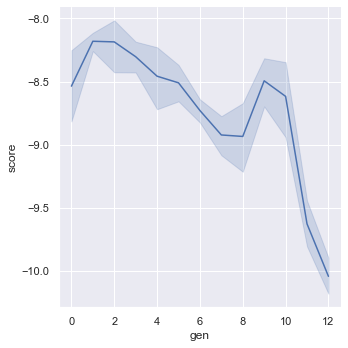

In [19]:
plt.figure(figsize=(8,6))
sns.set()
score = sns.relplot(x="gen", y="score", kind="line", data=final_joined)
plt.savefig('img/line_plot_score.svg',dpi=300)

### Binding Score and logP

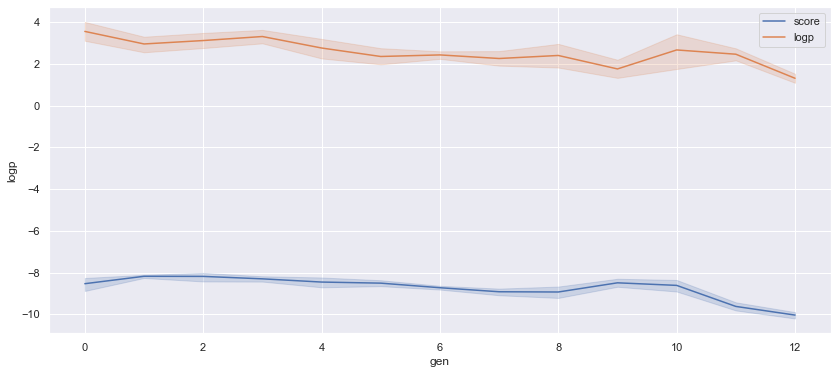

In [20]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

sns.lineplot(y=final_joined['score'],x=final_joined['gen'], label="score")
sns.lineplot(y=final_joined['logp'],x=final_joined['gen'], label="logp")

# Add label for horizontal axis
plt.xlabel("gen")

plt.savefig('img/line_plot_score_logp.svg',dpi=300)

<Figure size 1008x432 with 0 Axes>

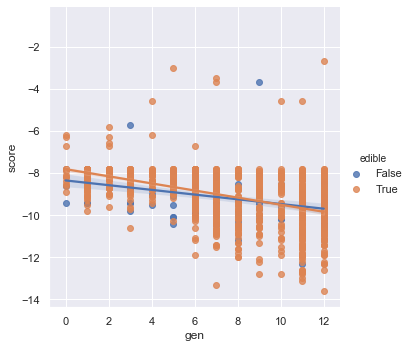

In [21]:
plt.figure(figsize=(14,6))
final["edible"] = (final_joined["logp"]<5) & (final_joined["logp"]>0)
sns.lmplot(x="gen",y="score", data=final, hue="edible")

plt.savefig('img/lm_plot_score_edible.svg',dpi=300)

### Max, Mean, Min of score

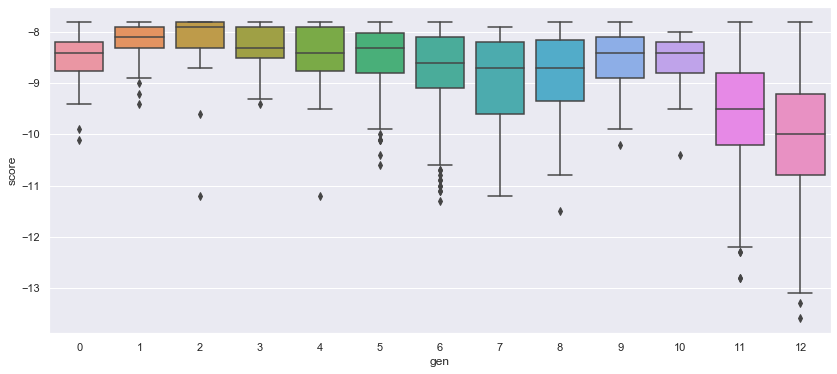

In [24]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

sns.boxplot(x="gen", y="score", data=final_joined)

# Add label for horizontal axis
plt.xlabel("gen")

sns.set()
plt.savefig('img/box_plot_score.svg',dpi=300)

### Max, Mean and Min of logP

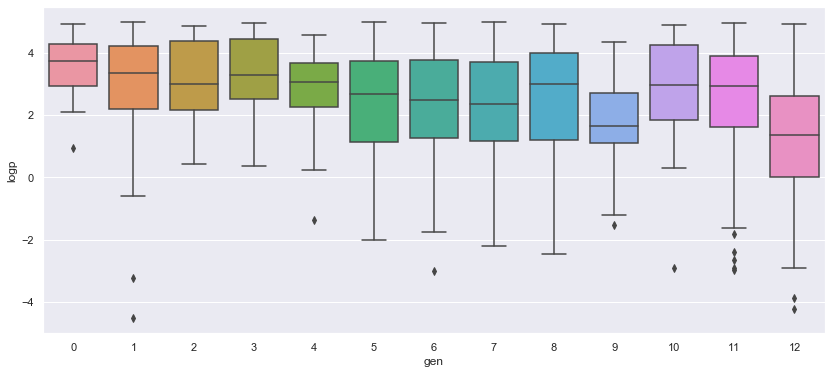

In [28]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

sns.boxplot(x="gen", y="logp", data=final_joined)

# Add label for horizontal axis
plt.xlabel("gen")

sns.set()
plt.savefig('img/box_plot_logp.svg',dpi=300)

### Gaussian of the logP

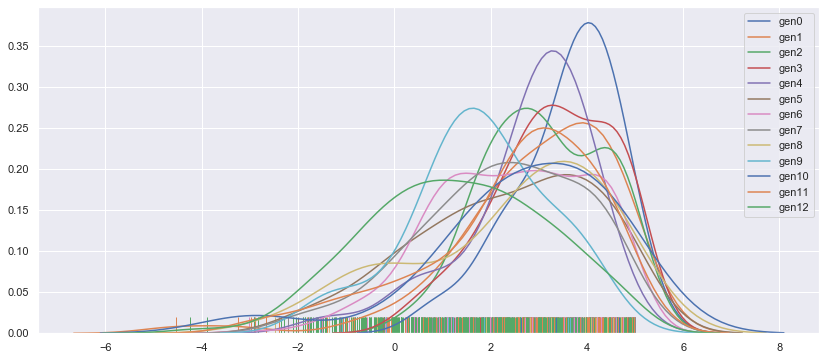

In [213]:
# Sort the dataframe by target
plt.figure(figsize=(14,6))

gen0_dist = final_joined.loc[final_joined['gen'] == 0]
gen1_dist = final_joined.loc[final_joined['gen'] == 1]
gen2_dist = final_joined.loc[final_joined['gen'] == 2]
gen3_dist = final_joined.loc[final_joined['gen'] == 3]
gen4_dist = final_joined.loc[final_joined['gen'] == 4]
gen5_dist = final_joined.loc[final_joined['gen'] == 5]
gen6_dist = final_joined.loc[final_joined['gen'] == 6]
gen7_dist = final_joined.loc[final_joined['gen'] == 7]
gen8_dist = final_joined.loc[final_joined['gen'] == 8]
gen9_dist = final_joined.loc[final_joined['gen'] == 9]
gen10_dist = final_joined.loc[final_joined['gen'] == 10]
gen11_dist = final_joined.loc[final_joined['gen'] == 11]
gen12_dist = final_joined.loc[final_joined['gen'] == 12]


sns.distplot(gen0_dist[['logp']], hist=False, rug=True, label="gen0")
sns.distplot(gen1_dist[['logp']], hist=False, rug=True, label="gen1")
sns.distplot(gen2_dist[['logp']], hist=False, rug=True, label="gen2")
sns.distplot(gen3_dist[['logp']], hist=False, rug=True, label="gen3")
sns.distplot(gen4_dist[['logp']], hist=False, rug=True, label="gen4")
sns.distplot(gen5_dist[['logp']], hist=False, rug=True, label="gen5")
sns.distplot(gen6_dist[['logp']], hist=False, rug=True, label="gen6")
sns.distplot(gen7_dist[['logp']], hist=False, rug=True, label="gen7")
sns.distplot(gen8_dist[['logp']], hist=False, rug=True, label="gen8")
sns.distplot(gen9_dist[['logp']], hist=False, rug=True, label="gen9")
sns.distplot(gen10_dist[['logp']], hist=False, rug=True, label="gen10")
sns.distplot(gen11_dist[['logp']], hist=False, rug=True, label="gen11")
sns.distplot(gen12_dist[['logp']], hist=False, rug=True, label="gen12")





### Correlations between attributes

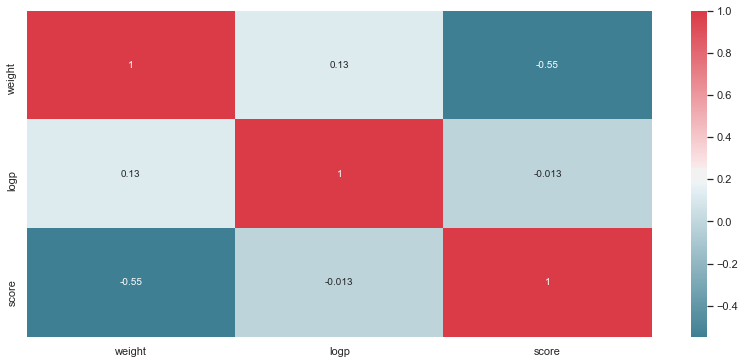

In [215]:
plt.figure(figsize=(14,6))
corr = final_joined.loc[:,final_joined.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, annot=True, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

### Violin Plot

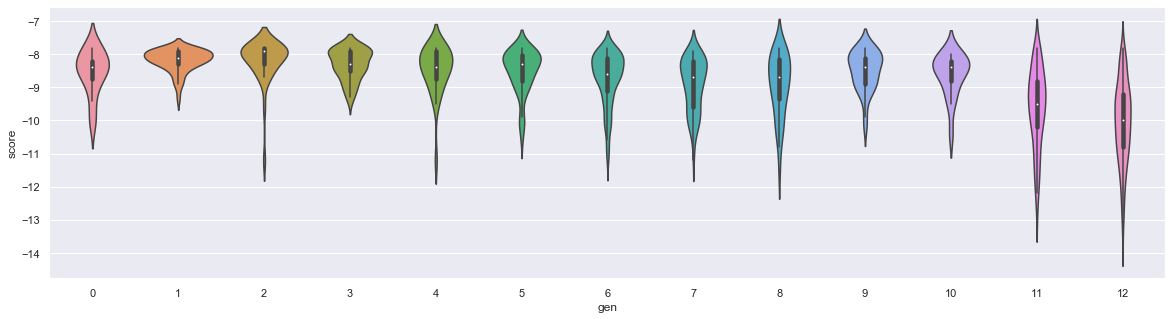

In [26]:
plt.figure(figsize=(20,5))
sns.violinplot(x="gen", y="score", data=final_joined)

sns.set()
plt.savefig('img/violin_plot_score.svg',dpi=300)

### KDE jointplot 

<Figure size 1440x360 with 0 Axes>

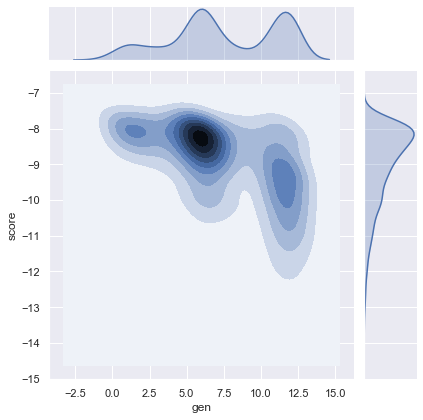

In [27]:
plt.figure(figsize=(20,5))

sns.jointplot(x="gen", y="score", data=final_joined, kind="kde")

sns.set()
plt.savefig('img/kde_joinplot_score.svg',dpi=300)